In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 14 17:39:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.14-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 123756
-rw-rw-r-- 1 scpark scpark        40  1월 14 17:39 events.out.tfevents.1705221153.GPUSVR01
-rw-rw-r-- 1 scpark scpark 126717079  1월 14 17:37 save_0
-rw-rw-r-- 1 scpark scpark        40  1월 14 17:32 events.out.tfevents.1705220744.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


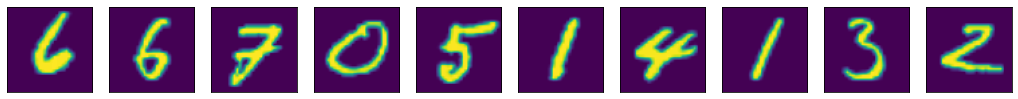

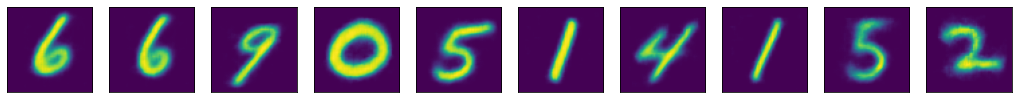

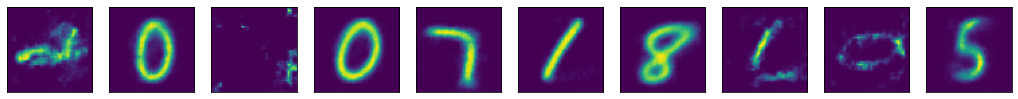

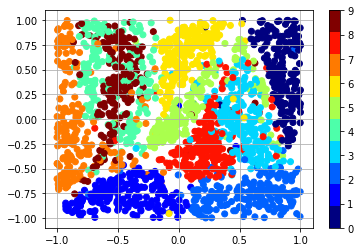

44001
lse_loss 0.005690275831148029
recon_loss 0.09233798086643219
44002
lse_loss 0.005523494305089116
recon_loss 0.08630681782960892
44003
lse_loss 0.005214090086519718
recon_loss 0.0886311836540699
44004
lse_loss 0.005565359769389033
recon_loss 0.08539359271526337
44005
lse_loss 0.005300129996612668
recon_loss 0.0912961296737194
44006
lse_loss 0.005318233044818044
recon_loss 0.08997903540730476
44007
lse_loss 0.005107413930818439
recon_loss 0.08913463205099106
44008
lse_loss 0.005159617820754647
recon_loss 0.08958804383873939
44009
lse_loss 0.00559954890049994
recon_loss 0.08986018598079681
44010
lse_loss 0.005960635701194405
recon_loss 0.08900348618626594
44011
lse_loss 0.006064269691705704
recon_loss 0.08973136991262436
44012
lse_loss 0.005774699710309505
recon_loss 0.08486332148313522
44013
lse_loss 0.005271500395610929
recon_loss 0.08829333111643792
44014
lse_loss 0.005616030422970653
recon_loss 0.09199357703328133
44015
lse_loss 0.005250906432047486
recon_loss 0.0936153151094913

lse_loss 0.005328267114236951
recon_loss 0.08859314620494843
44125
lse_loss 0.005454355897381902
recon_loss 0.09213500916957855
44126
lse_loss 0.005475135892629624
recon_loss 0.08702249675989152
44127
lse_loss 0.00577142252586782
recon_loss 0.08481877446174621
44128
lse_loss 0.0056096455082297325
recon_loss 0.08931262269616128
44129
lse_loss 0.005230976874008775
recon_loss 0.08766545504331588
44130
lse_loss 0.00548873315565288
recon_loss 0.08941286355257035
44131
lse_loss 0.005180294765159488
recon_loss 0.08948168978095054
44132
lse_loss 0.0059291554614901544
recon_loss 0.08929782211780549
44133
lse_loss 0.005687766754999757
recon_loss 0.08330909535288811
44134
lse_loss 0.005300762457773089
recon_loss 0.09065330773591995
44135
lse_loss 0.005493706045672298
recon_loss 0.089633858948946
44136
lse_loss 0.0059915925841778515
recon_loss 0.08781170397996903
44137
lse_loss 0.00515448059886694
recon_loss 0.09185504913330078
44138
lse_loss 0.005668965633958578
recon_loss 0.0939443938434124
4413

lse_loss 0.0058209510985761884
recon_loss 0.09004919826984406
44248
lse_loss 0.005656756274402141
recon_loss 0.09060166999697686
44249
lse_loss 0.005877603171393275
recon_loss 0.0882995568215847
44250
lse_loss 0.005294753611087799
recon_loss 0.08869844749569893
44251
lse_loss 0.005589972855523229
recon_loss 0.0914426438510418
44252
lse_loss 0.005945715308189392
recon_loss 0.09064669460058213
44253
lse_loss 0.005347458971664309
recon_loss 0.09124200493097305
44254
lse_loss 0.005736632319167256
recon_loss 0.08569674044847489
44255
lse_loss 0.005501370551064611
recon_loss 0.0934399425983429
44256
lse_loss 0.005502553097903729
recon_loss 0.08949617370963096
44257
lse_loss 0.005354906478896737
recon_loss 0.09038334786891937
44258
lse_loss 0.005604674573987722
recon_loss 0.09187833145260811
44259
lse_loss 0.005667142383754253
recon_loss 0.08824876621365547
44260
lse_loss 0.005278201494365931
recon_loss 0.0894293338060379
44261
lse_loss 0.005785808200016618
recon_loss 0.08908871412277222
4426

lse_loss 0.00544995809905231
recon_loss 0.08771902173757554
44371
lse_loss 0.005377832194790244
recon_loss 0.09082800373435021
44372
lse_loss 0.005765458103269339
recon_loss 0.08721401169896126
44373
lse_loss 0.005418569641187787
recon_loss 0.092734694480896
44374
lse_loss 0.005481223901733756
recon_loss 0.08663921356201172
44375
lse_loss 0.005590233532711863
recon_loss 0.08612463101744652
44376
lse_loss 0.005683500086888671
recon_loss 0.0885275088250637
44377
lse_loss 0.005388138862326741
recon_loss 0.08901260942220687
44378
lse_loss 0.005550270760431885
recon_loss 0.08416193351149559
44379
lse_loss 0.005648604827001691
recon_loss 0.08969478905200959
44380
lse_loss 0.0057692748960107565
recon_loss 0.08740149214863777
44381
lse_loss 0.0054898245725780725
recon_loss 0.08422415256500244
44382
lse_loss 0.005767849553376436
recon_loss 0.09242476373910904
44383
lse_loss 0.005540344351902604
recon_loss 0.09325243979692459
44384
lse_loss 0.00558787165209651
recon_loss 0.08866713047027588
4438

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        